In [12]:
import networkx as nx
from scipy import sparse
from bluepysnap import Circuit
import numpy as np
from sklearn.preprocessing import LabelEncoder
from matplotlib import cm
from scipy.sparse import hstack, vstack, csr_matrix
import os
import matplotlib.pyplot as plt

In [9]:
file_format = 'png'
dpi = 300
save_dir = '../output/graph_viz/'
os.makedirs(save_dir,exist_ok=True)

In [3]:
adj_path = '/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1/20211110-BioM/data/ca1_synaptome.npz'
synaptome = sparse.load_npz(adj_path)
connectome = synaptome.copy()
connectome[connectome > 0] = 1
# del synaptome

In [4]:
target = 'slice10'
CIRCUIT_DIR =  '/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1/20211110-BioM/sonata/circuit_config.json'
circuit = Circuit(CIRCUIT_DIR)
nodes = circuit.nodes["hippocampus_neurons"]
edges = circuit.edges["hippocampus_neurons__hippocampus_neurons__chemical_synapse"]
target_indices = nodes.ids(target)
target_synaptome = synaptome[target_indices,:][:,target_indices]
target_connectome = connectome[target_indices,:][:,target_indices]

In [5]:
mtypes_by_gid = np.array(nodes.get(target).mtype.values)

# Local Graph

In [6]:
g = nx.from_numpy_array(target_connectome.A)

In [7]:
label_dict = {i : {'mtype':mtypes_by_gid[i]} for i in range(len(mtypes_by_gid))}
nx.set_node_attributes(g,label_dict)

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/kurban/1616884/ipykernel_34172/457163045.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('jet'), node_size=1000, font_size=10)


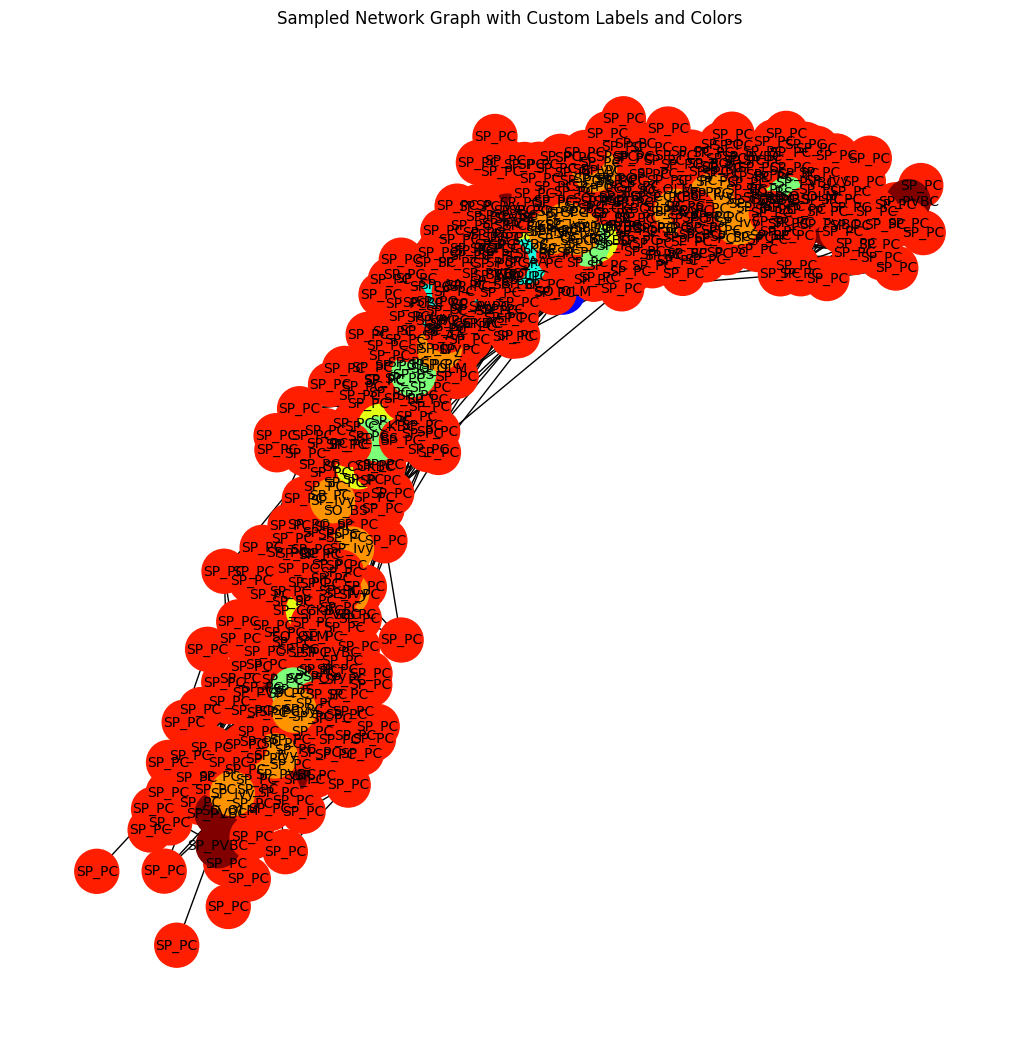

In [62]:
# Set node attributes
nx.set_node_attributes(g, label_dict)

# Specify the number of nodes you want to sample
num_samples = 500  # adjust this value to your needs

# Randomly sample nodes
nodes = list(g.nodes)
random.shuffle(nodes)
sampled_nodes = nodes[:num_samples]

# Create a subgraph with the sampled nodes
subgraph = g.subgraph(sampled_nodes)

# Define a label dictionary for the subgraph
labels = {node: data['mtype'] for node, data in subgraph.nodes(data=True)}

# Encode the labels to integers for coloring
encoder = LabelEncoder()
node_colors = encoder.fit_transform(list(labels.values()))

# Draw the subgraph with custom labels and colors
plt.figure(figsize=(10,10))  # adjust the figure size as needed
nx.draw(subgraph, labels=labels, with_labels=True, 
        node_color=node_colors,
        cmap=cm.get_cmap('jet'), node_size=1000, font_size=10)
plt.title("Sampled Network Graph with Custom Labels and Colors")
plt.show()


In [11]:
# Set node attributes
nx.set_node_attributes(g, label_dict)

# Specify the number of nodes you want to sample
num_samples = 500  # adjust this value to your needs

# Randomly sample nodes
nodes = list(g.nodes)
np.random.shuffle(nodes)
sampled_nodes = nodes[:num_samples]

# Create a subgraph with the sampled nodes
subgraph = g.subgraph(sampled_nodes)

# Define a label dictionary for the subgraph
labels = {node: data['mtype'] for node, data in subgraph.nodes(data=True)}

# Encode the labels to integers for coloring
encoder = LabelEncoder()
node_colors = encoder.fit_transform(list(labels.values()))

# Draw the subgraph with custom labels and colors
pos = nx.kamada_kawai_layout(subgraph)

NameError: name 'plt' is not defined

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/kurban/1616884/ipykernel_50331/1988045762.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('jet'), node_size=100, font_size=10)


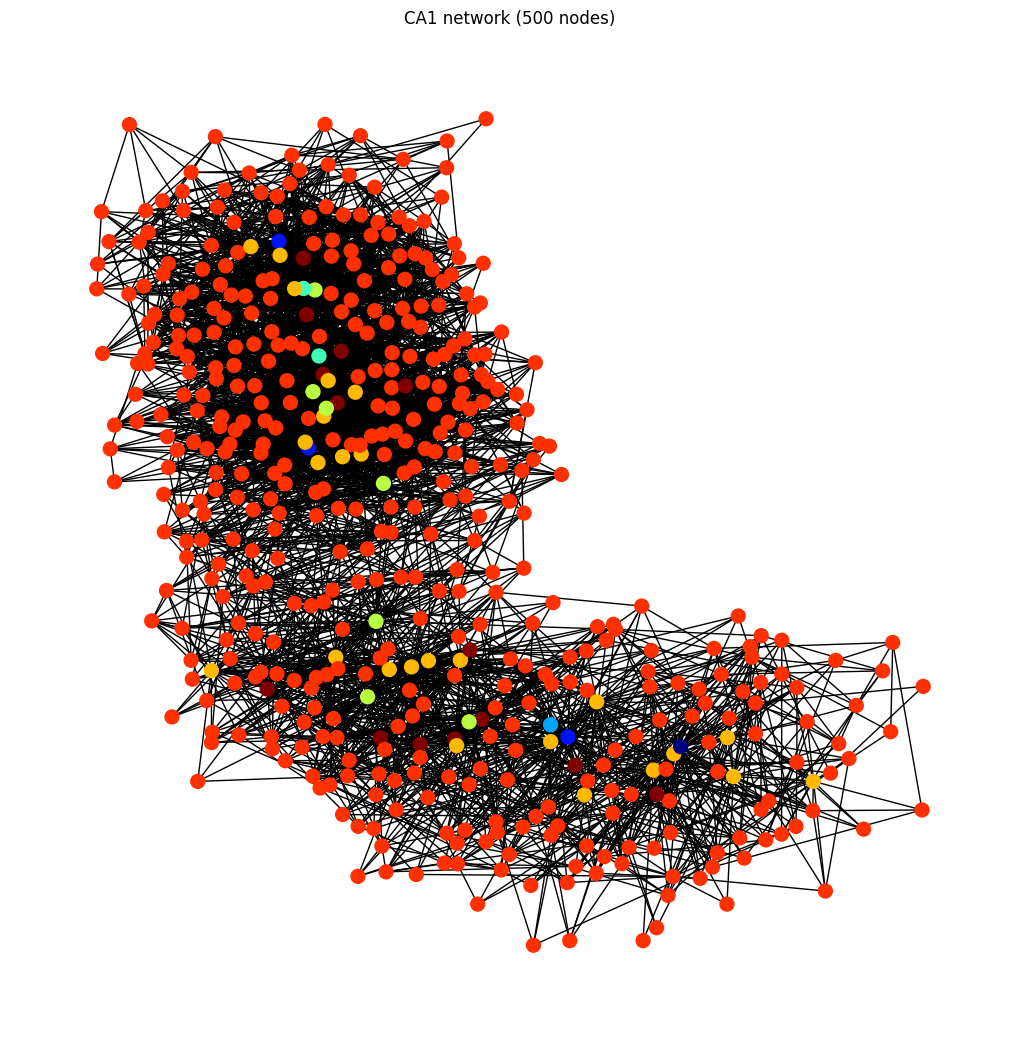

In [13]:

plt.figure(figsize=(10,10))  # adjust the figure size as needed
nx.draw(subgraph,pos, with_labels=False, 
        node_color=node_colors,
        cmap=cm.get_cmap('jet'), node_size=100, font_size=10)
plt.title("Sampled Network Graph with Custom Labels and Colors")
plt.title(f"CA1 network ({num_samples} nodes)")
plt.savefig(f'{save_dir}/{target}_local_graph.png')
# # Get unique labels for legend
# unique_labels = np.unique(list(labels.values()))
# unique_colors = np.unique(node_colors)
# # Create legend
# for i in range(len(unique_labels)):
#     plt.plot([], color=cm.get_cmap('jet')(unique_colors[i]), label=unique_labels[i], linestyle='None', marker='o')
# plt.legend()

plt.show()

# With Projections

In [14]:
adj_file_wproj = f'/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1/20211110-BioM/data/ca1_ca3_to_{target}_synaptome.npz'

In [15]:
adj_wproj = sparse.load_npz(adj_file_wproj)

In [16]:
projection_adj = adj_wproj[adj_wproj.shape[1]:,:] # get only projections

In [17]:
def make_square_sparse(adj):
    num_rows, num_cols = adj.shape

    if num_rows > num_cols:
        # Add columns of zeros
        zero_cols = csr_matrix((num_rows, num_rows - num_cols))
        adj_square = hstack([adj, zero_cols])

    elif num_cols > num_rows:
        # Add rows of zeros
        zero_rows = csr_matrix((num_cols - num_rows, num_cols))
        adj_square = vstack([adj, zero_rows])

    else:
        # The matrix is already square
        adj_square = adj

    return adj_square


In [18]:
num_sample_proj = 1000
selected_projections = np.random.choice(projection_adj.shape[0],num_sample_proj)
projection_adj_selected = projection_adj[selected_projections,:]
target_wproj = make_square_sparse(vstack([target_synaptome,projection_adj_selected]))

In [19]:
# Assuming your new adjacency matrix is already defined as projection_adj
g2 = nx.from_numpy_array(target_wproj.A)

In [20]:
label_dict_wproj = {i : {'mtype':mtypes_by_gid[i]} for i in range(len(mtypes_by_gid))}

for proj_idx in range(num_sample_proj):
    offset = len(mtypes_by_gid) 
    label_dict_wproj[offset+proj_idx] = {'mtype':'SC'}

nx.set_node_attributes(g2,label_dict_wproj)

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/kurban/1616884/ipykernel_34172/2467885778.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('jet'), node_size=100, font_size=10)


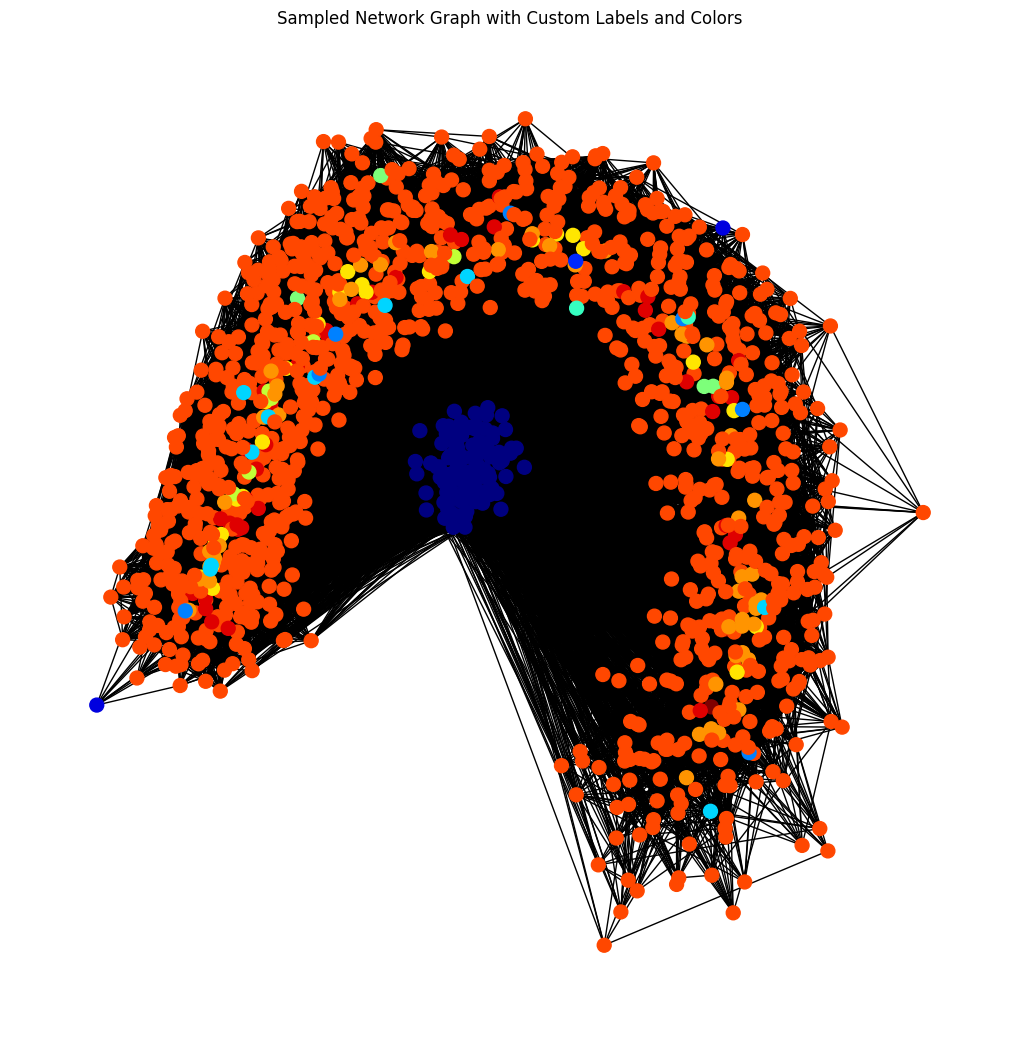

In [123]:
# Randomly sample 1% of nodes
percent_sample = 10
num_samples_g2 = int(percent_sample/100 * g2.number_of_nodes())  # 1% of nodes

# Randomly sample nodes
nodes_g2 = list(g2.nodes)
random.shuffle(nodes_g2)
sampled_nodes_g2 = nodes_g2[:num_samples_g2]

# Create a subgraph with the sampled nodes
subgraph_g2 = g2.subgraph(sampled_nodes_g2)

labels_wproj = {node: data['mtype'] for node, data in subgraph_g2.nodes(data=True)}
# Encode the labels to integers for coloring
encoder = LabelEncoder()
node_colors = encoder.fit_transform(list(labels_wproj.values()))

# Draw the subgraph with custom labels and colors
plt.figure(figsize=(10,10))  # adjust the figure size as needed
nx.draw(subgraph_g2, labels=labels_wproj, with_labels=False, 
        node_color=node_colors,
        cmap=cm.get_cmap('jet'), node_size=100, font_size=10)
plt.title("Sampled Network Graph with Custom Labels and Colors")
plt.show()

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/kurban/1616884/ipykernel_50331/1256118640.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('jet'), node_size=100, font_size=10)


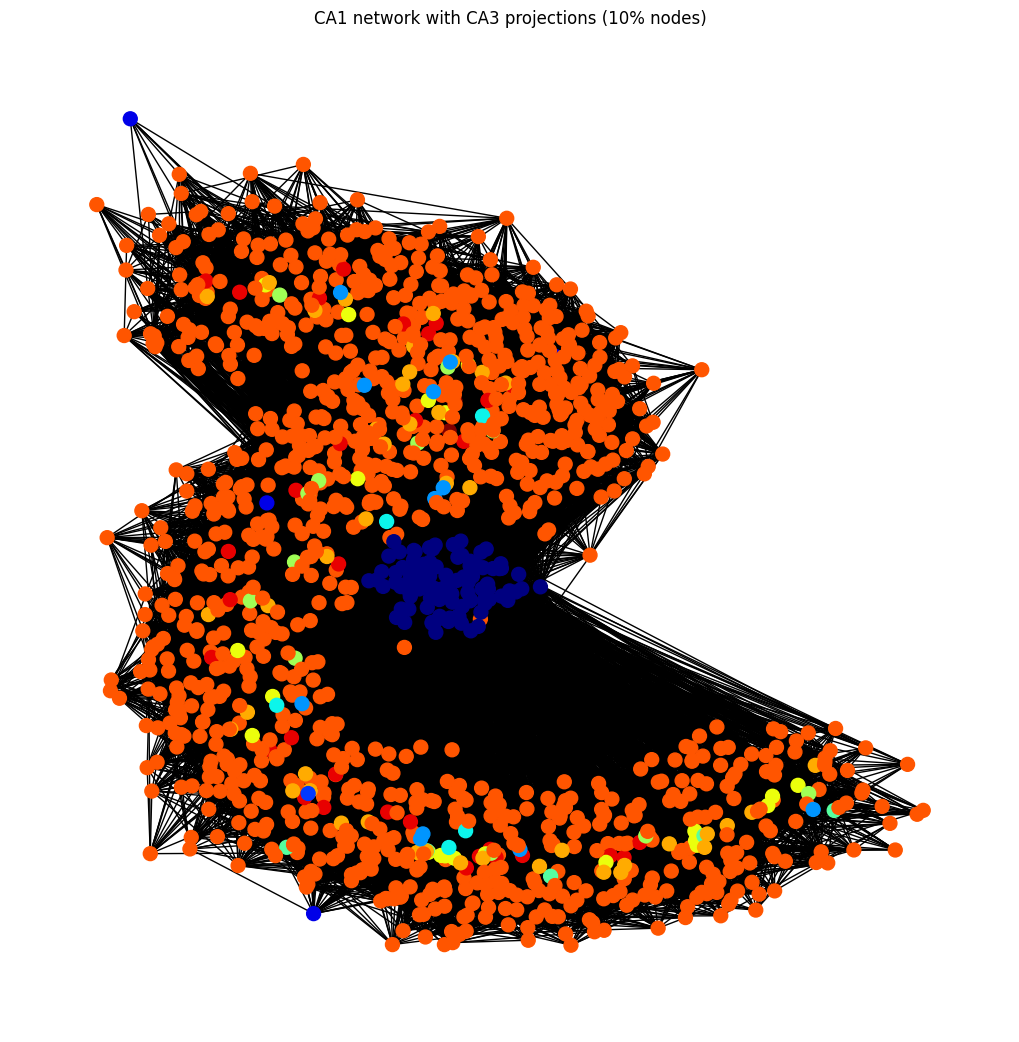

In [22]:
# Randomly sample 1% of nodes
percent_sample = 10
num_samples_g2 = int(percent_sample/100 * g2.number_of_nodes())  # 1% of nodes

# Randomly sample nodes
nodes_g2 = list(g2.nodes)
np.random.shuffle(nodes_g2)
sampled_nodes_g2 = nodes_g2[:num_samples_g2]

# Create a subgraph with the sampled nodes
subgraph_g2 = g2.subgraph(sampled_nodes_g2)

labels_wproj = {node: data['mtype'] for node, data in subgraph_g2.nodes(data=True)}
# Encode the labels to integers for coloring
encoder = LabelEncoder()
node_colors = encoder.fit_transform(list(labels_wproj.values()))

pos = nx.spring_layout(subgraph_g2)

# Draw the subgraph with custom labels and colors
plt.figure(figsize=(10,10))  # adjust the figure size as needed
nx.draw(subgraph_g2,pos, labels=labels_wproj, with_labels=False, 
        node_color=node_colors,
        cmap=cm.get_cmap('jet'), node_size=100, font_size=10)
plt.title(f"CA1 network with CA3 projections ({percent_sample}% nodes)")
plt.savefig(f'{save_dir}/{target}_proj_spring.png')
plt.show()

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/kurban/1616884/ipykernel_50331/998225244.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('jet'), node_size=100, font_size=10)


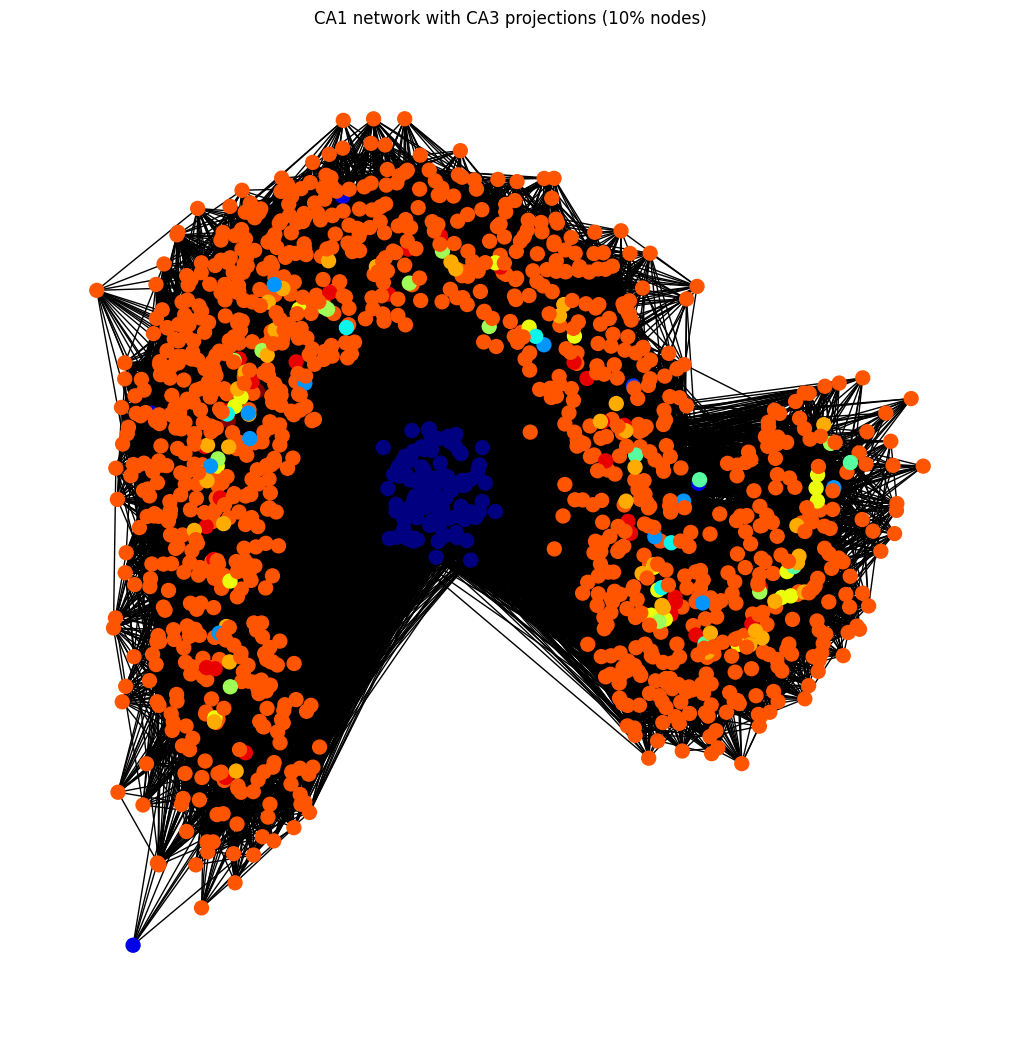

In [23]:
pos = nx.spring_layout(subgraph_g2)

# Draw the subgraph with custom labels and colors
plt.figure(figsize=(10,10))  # adjust the figure size as needed
nx.draw(subgraph_g2,pos, labels=labels_wproj, with_labels=False, 
        node_color=node_colors,
        cmap=cm.get_cmap('jet'), node_size=100, font_size=10)
plt.title(f"CA1 network with CA3 projections ({percent_sample}% nodes)")
plt.savefig(f'{save_dir}/{target}_proj_spring2.png')
plt.show()

In [ ]:
# Randomly sample 1% of nodes
percent_sample = 10
num_samples_g2 = int(percent_sample/100 * g2.number_of_nodes())  # 1% of nodes

# Randomly sample nodes
nodes_g2 = list(g2.nodes)
random.shuffle(nodes_g2)
sampled_nodes_g2 = nodes_g2[:num_samples_g2]

# Create a subgraph with the sampled nodes
subgraph_g2 = g2.subgraph(sampled_nodes_g2)

labels_wproj = {node: data['mtype'] for node, data in subgraph_g2.nodes(data=True)}
# Encode the labels to integers for coloring
encoder = LabelEncoder()
node_colors = encoder.fit_transform(list(labels_wproj.values()))

pos = nx.kamada_kawai_layout(subgraph_g2)

# Draw the subgraph with custom labels and colors
plt.figure(figsize=(10,10))  # adjust the figure size as needed
nx.draw(subgraph_g2,pos, labels=labels_wproj, with_labels=False, 
        node_color=node_colors,
        cmap=cm.get_cmap('jet'), node_size=100, font_size=10)
plt.title(f"CA1 network with CA3 projections ({percent_sample}% nodes)")
plt.savefig(f'{save_dir}/{target}_with_proj_kawai.png')
plt.show()